In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn # PyTorch's building blocks for neural networks

torch.__version__

'2.3.1'

<br>
<br>

# 1. Preparing the dataset

In [2]:
from sklearn.datasets import make_circles # "Circular" dataset for binary classification

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

print(X[:5], '\n\n', y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 

 [1 1 1 1 0]


In [3]:
y = y.reshape(-1, 1) # 2차원 행렬로 변환 (모양을 다시 바꿔주기) <- One-hot encoding 불필요

print(y[:5])

[[1]
 [1]
 [1]
 [1]
 [0]]


In [4]:
df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y[:, 0]})

df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
df['label'].value_counts() # 카테고리별 출현 횟수 카운트

label
1    500
0    500
Name: count, dtype: int64

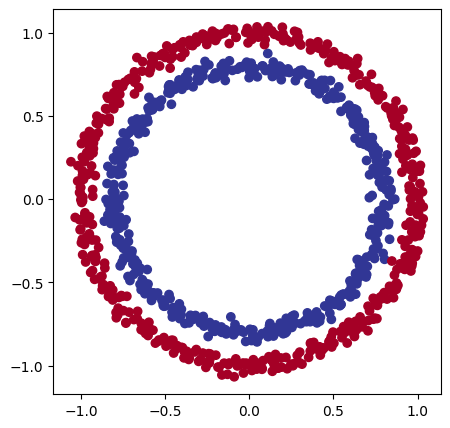

In [7]:
plt.figure(figsize=(5, 5))

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap='RdYlBu'); # 산점도 (Scatter plots)

In [8]:
# Numpy array -> PyTorch tensor

X = torch.from_numpy(X).type(torch.float) # Numpy"로부터" & torch.float == float32
y = torch.from_numpy(y).type(torch.float)

print(X[:5], '\n\n', y[:5])

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]]) 

 tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]])


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42) 

<br>
<br>

# 2. Build the model (Binary classification)

<br>

## Pytorch Cheet sheet @ https://pytorch.org/tutorials/beginner/ptcheat.html

In [12]:
device = "mps" if torch.backends.mps.is_available() else "cpu" # "cuda"가 사용 가능하다면(if it "is available")

device

'mps'

<br>
<br>

### 1) **nn.Module** 클래스를 상속받아 모델 생성을 위한 클래스를 직접 구현


In [13]:
class BinaryCircle(nn.Module): 
    
    
    def __init__(self):
        
        super().__init__()
        
        self.hidden_1 = nn.Linear(in_features=2, out_features=5) # 2 -> 5 (there is no activation function yet.)
        self.hidden_2 = nn.Linear(in_features=5, out_features=1) # 5 -> 1 (-> sigmoid)
    
    
    def forward(self, x): # forward-pass
        
        result = self.hidden_1(x) # x -> hidden_1
        result = self.hidden_2(result) # hidden_1 -> hidden_2
        
        return result

In [14]:
model = BinaryCircle().to(device) # 특정한 디바이스"로"

model

BinaryCircle(
  (hidden_1): Linear(in_features=2, out_features=5, bias=True)
  (hidden_2): Linear(in_features=5, out_features=1, bias=True)
)

<br>
<br>

### 2) **nn.Sequential** 클래스를 활용하여 간단한 방식으로 모델 구현

<br>

#### -> Sequential한 흐름으로만 모델 구현이 가능 (straight-forward computations)
#### -> 복잡한 구조를 가진 모델을 구현하려면 nn.Sequential 사용하는 방식 대신 nn.Module 상속하는 방식을 활용

In [15]:
model = nn.Sequential( # Make a sequential model
    
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
    
).to(device) # 특정한 디바이스"로"

model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
# 모델을 evaluation mode로 설정
model.eval()

with torch.inference_mode(): # Set "inference mode"
    
    # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    untrained_predictions = model(X_test.to(device)) # 모델 & 데이터는 동일한 디바이스 위에 위치해있어야 함

In [17]:
print(len(untrained_predictions))
print(len(y_test))

print(untrained_predictions[:10])

300
300
tensor([[-0.1402],
        [-0.1681],
        [-0.0778],
        [-0.1579],
        [-0.0950],
        [-0.1119],
        [-0.1769],
        [-0.1638],
        [-0.0772],
        [-0.1702]], device='mps:0')


<br>
<br>

# 3. Train the model 

<hr>
<br>

#### torch.nn.**BCELoss**() <- should be used with sigmoid (nn.Sigmoid + nn.BCELoss)<br><br> :	 Binary cross-entropy
<br>

<hr>
<br>

#### torch.nn.**BCEWithLogitsLoss**() <- more numerically stable (than nn.Sigmoid + nn.BCELoss)<br><br> : Binary cross-entropy **with built-in Sigmoid**
<br>

<hr>

<br>
<br>

### 1) Logits & Sigmoid


In [18]:
logits = model(X_test.to(device))

logits[:5] # 선형결합까지만 마친 상태 (activation function 적용 전)

tensor([[-0.1402],
        [-0.1681],
        [-0.0778],
        [-0.1579],
        [-0.0950]], device='mps:0', grad_fn=<SliceBackward0>)

In [19]:
y_predicted = torch.sigmoid(logits) # Usage of sigmoid - 1

y_predicted[:5] # 각 데이터의 class가 1일 확률값

tensor([[0.4650],
        [0.4581],
        [0.4806],
        [0.4606],
        [0.4763]], device='mps:0', grad_fn=<SliceBackward0>)

In [20]:
sigmoid_function = torch.nn.Sigmoid() # Usage of sigmoid - 2

y_predicted = sigmoid_function(logits)

y_predicted[:5] # 각 데이터의 class가 1일 확률값

tensor([[0.4650],
        [0.4581],
        [0.4806],
        [0.4606],
        [0.4763]], device='mps:0', grad_fn=<SliceBackward0>)

In [21]:
y_preds = torch.round(y_predicted) # 반올림

y_preds[:5] # 각 데이터에 대한 예측이 마쳐진 class 값

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='mps:0', grad_fn=<SliceBackward0>)

In [47]:
# torch.round(torch.sigmoid(model(X_test.to(device))))[:5]

<br>
<br>

### 2) Model training


In [22]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model = BinaryCircle().to(device) # 특정한 디바이스"로"

loss_fn = nn.BCELoss() # Binary Cross-entropy + built-in Sigmoid (accepting "logits")

optimizer = torch.optim.Adam(params=model.parameters(),  # "parameters" to optimize (apply gradient descent)
                             lr=0.01) # "l"earning "r"ate 

In [23]:
def get_accuracy(y_true, y_pred):
    
    num_correct = torch.eq(y_true, y_pred).sum().item() # 정답을 맞춘 횟수
    
    accuracy = (num_correct / len(y_pred)) * 100 # (정답을 맞춘 횟수 / 전체 예측 횟수) * 100
    
    return accuracy

In [26]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(100):
    
    # 모델을 training mode로 설정 (default state)
    model.train()

    # 1. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    logits = model(X_train)
    y_predicted = torch.round(torch.sigmoid(logits)) #  logits -> (sigmoid) predicted probabilities -> (round) predicted class numbers

    # 2. Training cost 계산 (Cost function 계산)
    loss_train = loss_fn(logits, y_train) # <- nn.BCEWithLogitsLoss() : built-in Sigmoid
    # loss_train = loss_fn(torch.sigmoid(logits), y_train) # <- nn.BCELoss() : we need to apply sigmoid first

    # 3. Optimizer 내부의 이전 gradient 값 초기화 (Make "grad" to "zero")
    optimizer.zero_grad()

    # 4. Back-propagation ("Backward" propagation)
    loss_train.backward()

    # 5. Gradient descent 진행 (Take a "step" to update parameters)
    optimizer.step()

    
    # 모델을 evaluation mode로 설정
    model.eval()
    
    with torch.inference_mode(): # Set "inference mode"
        
        # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
        logits_test = model(X_test)
        y_predicted_test = torch.round(torch.sigmoid(logits_test))
        
        # Test cost 계산
        loss_test = loss_fn(logits_test, y_test)
        

    acc_train = get_accuracy(y_true=y_train, y_pred=y_predicted) 
    acc_test  = get_accuracy(y_true=y_test, y_pred=y_predicted_test)
    
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test loss: {loss_test:.5f}, Test acc: {acc_test:.2f}%")

Epoch: 0 | Loss: 50.80532, Acc: 49.14% | Test loss: 47.96445, Test acc: 52.00%
Epoch: 10 | Loss: 1.01514, Acc: 50.86% | Test loss: 0.93650, Test acc: 48.00%
Epoch: 20 | Loss: 0.82463, Acc: 50.86% | Test loss: 0.79120, Test acc: 48.00%
Epoch: 30 | Loss: 0.78005, Acc: 50.86% | Test loss: 0.75631, Test acc: 48.00%
Epoch: 40 | Loss: 0.76556, Acc: 50.86% | Test loss: 0.74499, Test acc: 48.00%
Epoch: 50 | Loss: 0.76034, Acc: 50.86% | Test loss: 0.74093, Test acc: 48.00%
Epoch: 60 | Loss: 0.75840, Acc: 50.86% | Test loss: 0.73942, Test acc: 48.00%
Epoch: 70 | Loss: 0.75767, Acc: 50.86% | Test loss: 0.73885, Test acc: 48.00%
Epoch: 80 | Loss: 0.75740, Acc: 50.86% | Test loss: 0.73864, Test acc: 48.00%
Epoch: 90 | Loss: 0.75730, Acc: 50.86% | Test loss: 0.73856, Test acc: 48.00%


### -> Test data 기준 정확도가 겨우 50%?

<br>
<br>

<br>
<br>

# 4. Improve the model 

<br>
<br>

### 1) 기존 모델 예측결과 시각화

In [28]:
from plot_functions import plot_predictions, plot_decision_boundary

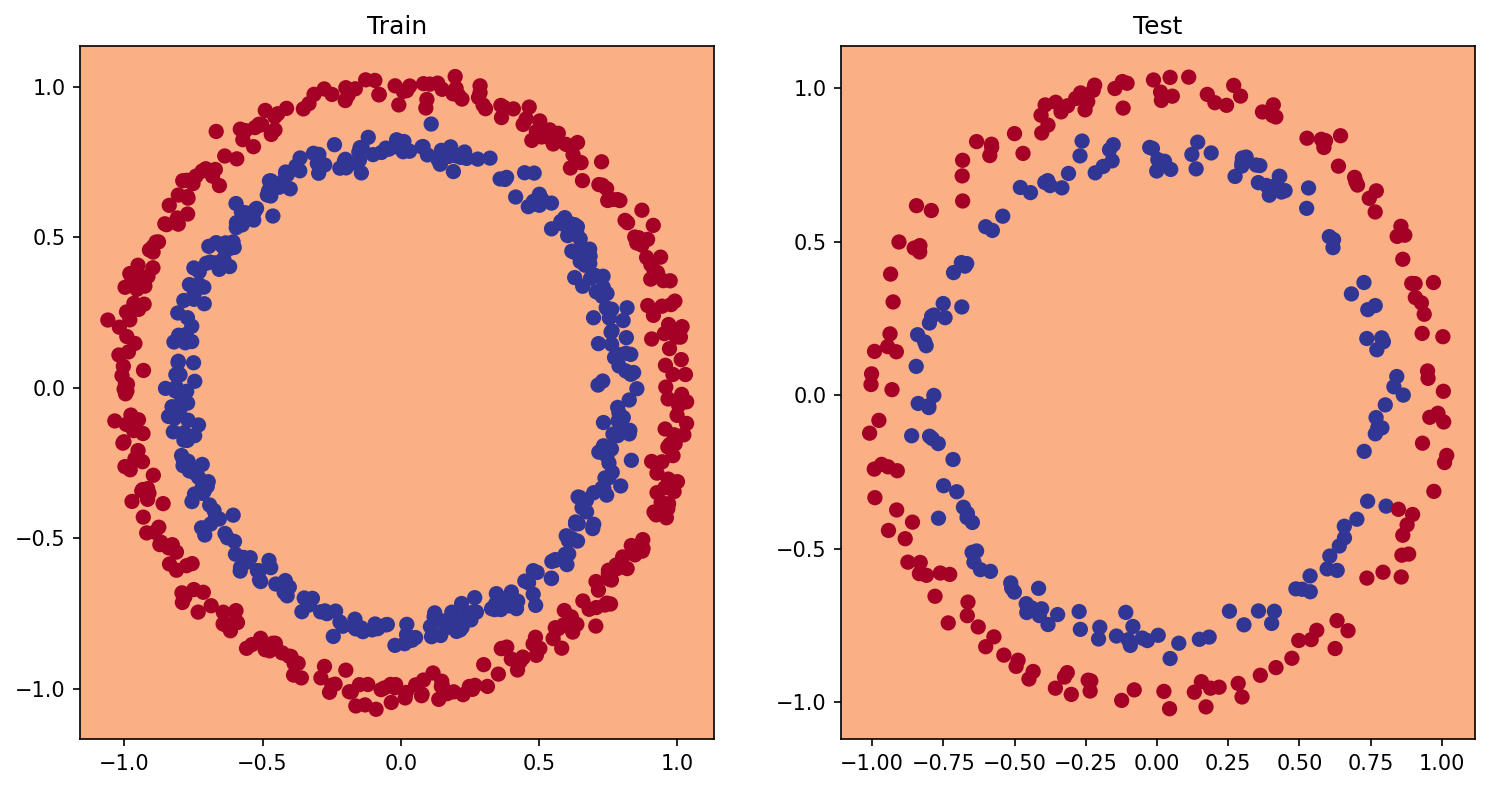

In [29]:
plt.figure(figsize=(12, 6), dpi=150) # figure size & dots per inch

plt.subplot(1, 2, 1) # 작은 도화지 생성
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

<br>
<br>

### 2) 기존 모델에 Hidden layer 추가

In [30]:
class BinaryCircleV2(nn.Module):
    
    
    def __init__(self):
        
        super().__init__()
        
        self.hidden_1 = nn.Linear(in_features=2, out_features=10) # 2 -> 10 (there is no activation function yet.)
        self.hidden_2 = nn.Linear(in_features=10, out_features=10) # 10 -> 10 (there is no activation function yet.)
        self.hidden_3 = nn.Linear(in_features=10, out_features=1) # 10 -> 1 (-> sigmoid)
    
    
    def forward(self, x):
        
        result = self.hidden_1(x)
        result = self.hidden_2(result)
        result = self.hidden_3(result)
        
        return result

In [31]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model_v2 = BinaryCircleV2().to(device) # 모델 초기화 

loss_fn = nn.BCEWithLogitsLoss() # Binary Cross-entropy + built-in Sigmoid (accepting "logits")

optimizer = torch.optim.Adam(params=model_v2.parameters(),  # "parameters" to optimize (apply gradient descent)
                             lr=0.01) # "l"earning "r"ate 

In [32]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(1000): # epoch 변경 : 100 -> 1000
    
    # 모델을 training mode로 설정 (default state)
    model_v2.train()

    # 1. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    logits = model_v2(X_train)
    y_predicted = torch.round(torch.sigmoid(logits)) #  logits -> predicted probabilities -> predicted class numbers

    # 2. Training cost 계산 (Cost function 계산)
    loss_train = loss_fn(logits, y_train) # <- nn.BCEWithLogitsLoss() : built-in Sigmoid
    # loss_train = loss_fn(torch.sigmoid(logits), y_train) # <- nn.BCELoss() : we need to apply sigmoid first

    # 3. Optimizer 내부의 이전 gradient 값 초기화 (Make "grad" to "zero")
    optimizer.zero_grad()

    # 4. Back-propagation ("Backward" propagation)
    loss_train.backward()

    # 5. Gradient descent 진행 (Take a "step" to update parameters)
    optimizer.step()

    
    # 모델을 evaluation mode로 설정
    model_v2.eval()
    
    with torch.inference_mode(): # Set "inference mode"
        
        # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
        logits_test = model_v2(X_test)
        y_predicted_test = torch.round(torch.sigmoid(logits_test))
        
        # Test cost 계산
        loss_test = loss_fn(logits_test, y_test)
        

    acc_train = get_accuracy(y_true=y_train, y_pred=y_predicted) 
    acc_test  = get_accuracy(y_true=y_test, y_pred=y_predicted_test)
    
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test loss: {loss_test:.5f}, Test acc: {acc_test:.2f}%")

Epoch: 0 | Loss: 0.69379, Acc: 50.86% | Test loss: 0.69426, Test acc: 48.00%
Epoch: 100 | Loss: 0.69279, Acc: 53.43% | Test loss: 0.69523, Test acc: 50.33%
Epoch: 200 | Loss: 0.69279, Acc: 53.57% | Test loss: 0.69524, Test acc: 50.33%
Epoch: 300 | Loss: 0.69279, Acc: 53.86% | Test loss: 0.69520, Test acc: 50.67%
Epoch: 400 | Loss: 0.69279, Acc: 53.57% | Test loss: 0.69524, Test acc: 50.33%
Epoch: 500 | Loss: 0.69279, Acc: 53.57% | Test loss: 0.69524, Test acc: 50.33%
Epoch: 600 | Loss: 0.69279, Acc: 53.57% | Test loss: 0.69524, Test acc: 50.33%
Epoch: 700 | Loss: 0.69279, Acc: 53.43% | Test loss: 0.69528, Test acc: 50.33%
Epoch: 800 | Loss: 0.69279, Acc: 53.57% | Test loss: 0.69524, Test acc: 50.33%
Epoch: 900 | Loss: 0.69279, Acc: 53.57% | Test loss: 0.69524, Test acc: 50.33%


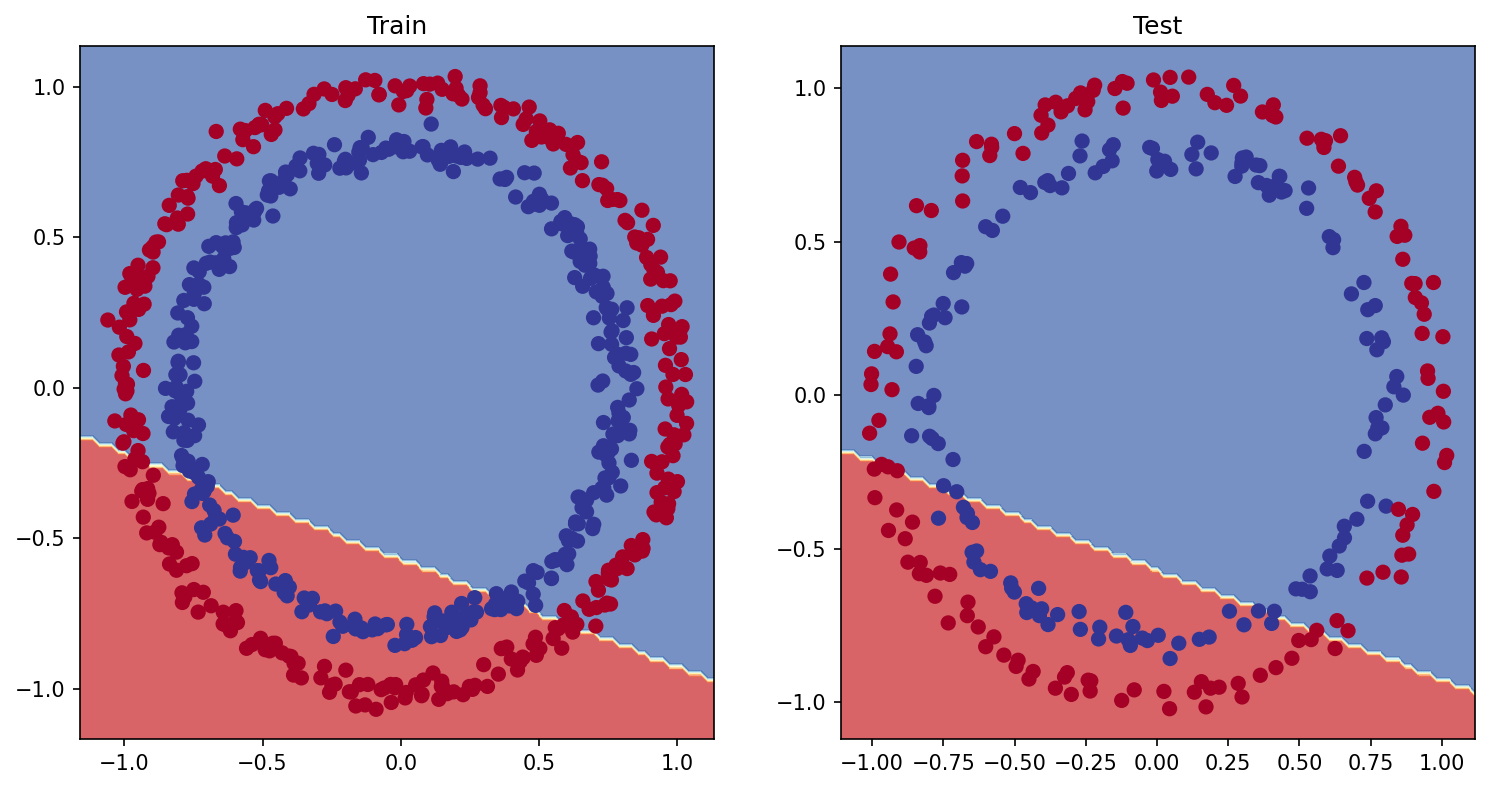

In [33]:
plt.figure(figsize=(12, 6), dpi=150) # figure size & dot per inch

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_v2, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_v2, X_test, y_test)

<br>
<br>

### 3) 기존 모델에 Non-linearity (비선형성) 추가

In [ ]:
# # Activations @ https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

# torch.nn.ReLU
# torch.nn.ELU 
# torch.nn.PReLU 
# torch.nn.LeakyReLU
# torch.nn.Sigmoid 
# torch.nn.Tanh 
# torch.nn.Softmax

# # RReLu, SELU, CELU, GELU, ReLU6, 
# # Threshold, Hardshrink, HardTanh,LogSigmoid, Softplus, SoftShrink,
# # Softsign, TanhShrink, Softmin, Softmax2d, LogSoftmax, AdaptiveSoftmaxWithLoss

In [34]:
class BinaryCircleV3(nn.Module):
    
    
    def __init__(self):
        
        super().__init__()
        
        self.hidden_1 = nn.Linear(in_features=2, out_features=10) # 2 -> 10 (there is no activation function yet.)
        self.hidden_2 = nn.Linear(in_features=10, out_features=10) # 10 -> 10 (there is no activation function yet.)
        self.hidden_3 = nn.Linear(in_features=10, out_features=1) # 10 -> 1 (-> sigmoid)
        self.relu = nn.ReLU() # ReLU Activation function (or ELU / PReLU / LeakyReLU / Sigmoid / Tanh / etc.)
    
    
    def forward(self, x):
        
        z = self.hidden_1(x) # x -> hidden_1
        z = self.relu(z) # hidden_1 -> ReLU
        z = self.hidden_2(z) # ReLU -> hidden_2
        z = self.relu(z) # hidden_2 -> ReLU
        z = self.hidden_3(z) # ReLU -> hidden_3
        
        return z

In [35]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model_v3 = BinaryCircleV3().to(device) # 모델 초기화 

loss_fn = nn.BCEWithLogitsLoss() # Binary Cross-entropy + built-in Sigmoid (accepting "logits")

optimizer = torch.optim.Adam(params=model_v3.parameters(),  # "parameters" to optimize (apply gradient descent)
                             lr=0.01) # "l"earning "r"ate 

In [36]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(1000): # epoch 변경 : 100 -> 1000
    
    # 모델을 training mode로 설정 (default state)
    model_v3.train()

    # 1. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    logits = model_v3(X_train)
    y_predicted = torch.round(torch.sigmoid(logits)) #  logits -> predicted probabilities -> predicted class numbers

    # 2. Training cost 계산 (Cost function 계산)
    loss_train = loss_fn(logits, y_train) # <- nn.BCEWithLogitsLoss() : built-in Sigmoid
    # loss_train = loss_fn(torch.sigmoid(logits), y_train) # <- nn.BCELoss() : we need to apply sigmoid first

    # 3. Optimizer 내부의 이전 gradient 값 초기화 (Make "grad" to "zero")
    optimizer.zero_grad()

    # 4. Back-propagation ("Backward" propagation)
    loss_train.backward()

    # 5. Gradient descent 진행 (Take a "step" to update parameters)
    optimizer.step()

    
    # 모델을 evaluation mode로 설정
    model_v3.eval()
    
    with torch.inference_mode(): # Set "inference mode"
        
        # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
        logits_test = model_v3(X_test)
        y_predicted_test = torch.round(torch.sigmoid(logits_test))
        
        # Test cost 계산
        loss_test = loss_fn(logits_test, y_test)
        

    acc_train = get_accuracy(y_true=y_train, y_pred=y_predicted) 
    acc_test  = get_accuracy(y_true=y_test, y_pred=y_predicted_test)
    
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test loss: {loss_test:.5f}, Test acc: {acc_test:.2f}%")

Epoch: 0 | Loss: 0.69276, Acc: 50.86% | Test loss: 0.69278, Test acc: 48.00%
Epoch: 100 | Loss: 0.15637, Acc: 99.57% | Test loss: 0.18120, Test acc: 98.33%
Epoch: 200 | Loss: 0.01240, Acc: 100.00% | Test loss: 0.02351, Test acc: 100.00%
Epoch: 300 | Loss: 0.00495, Acc: 100.00% | Test loss: 0.01286, Test acc: 100.00%
Epoch: 400 | Loss: 0.00279, Acc: 100.00% | Test loss: 0.00944, Test acc: 100.00%
Epoch: 500 | Loss: 0.00181, Acc: 100.00% | Test loss: 0.00768, Test acc: 100.00%
Epoch: 600 | Loss: 0.00128, Acc: 100.00% | Test loss: 0.00659, Test acc: 100.00%
Epoch: 700 | Loss: 0.00096, Acc: 100.00% | Test loss: 0.00583, Test acc: 100.00%
Epoch: 800 | Loss: 0.00074, Acc: 100.00% | Test loss: 0.00529, Test acc: 100.00%
Epoch: 900 | Loss: 0.00059, Acc: 100.00% | Test loss: 0.00489, Test acc: 100.00%


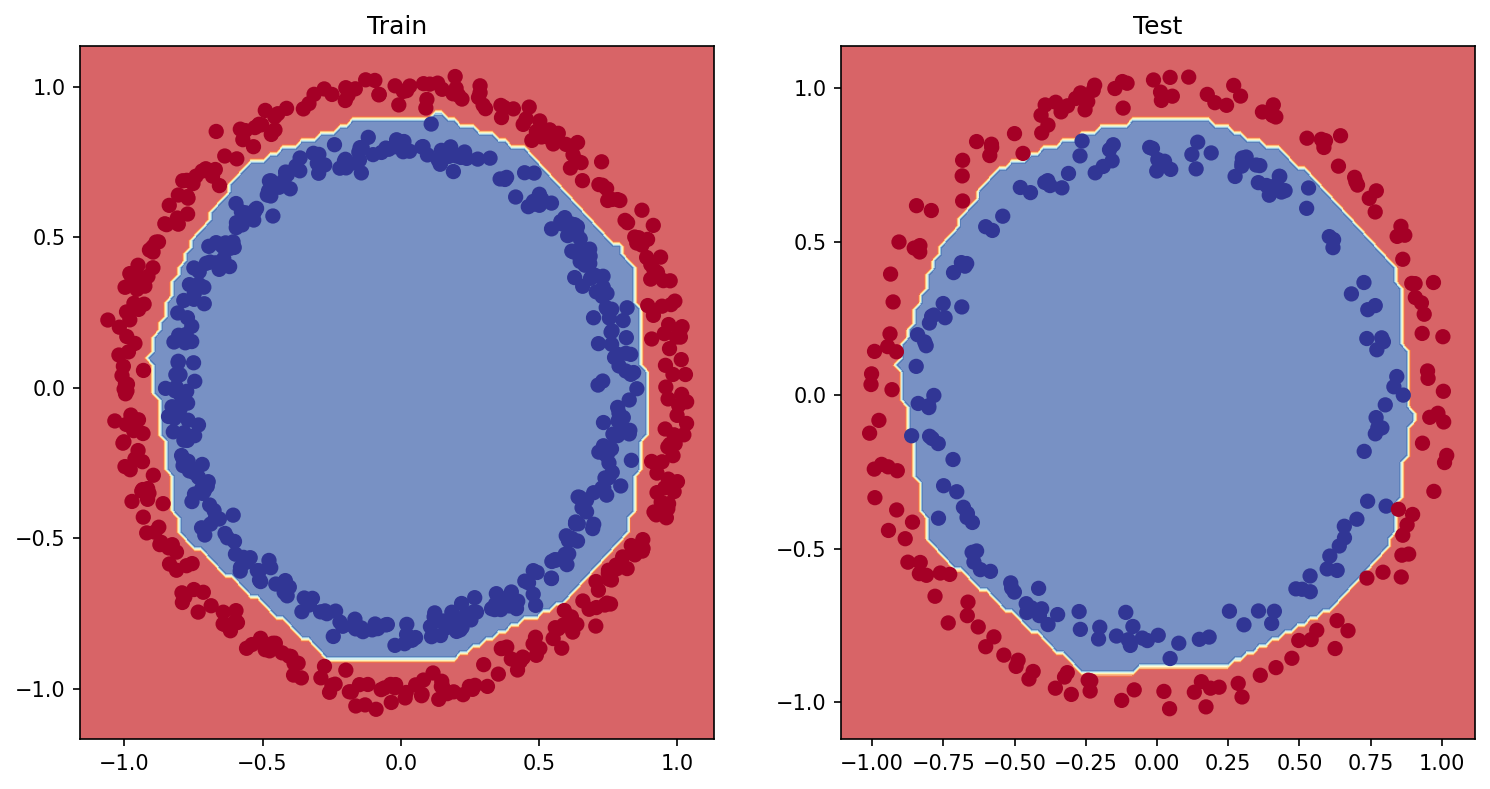

In [37]:
plt.figure(figsize=(12, 6), dpi=150) # figure size & dot per inch

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_v3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_v3, X_test, y_test)

<br>
<br>

# 5. Test the model 

In [43]:
# 1. 모델을 evaluation mode로 설정
model_v3.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    logits = model_v3(X_test).to(device)
    y_predicted = torch.round(torch.sigmoid(logits)) #  logits -> predicted probabilities -> predicted class numbers

acc_test = get_accuracy(y_true=y_test.to(device), y_pred=y_predicted)

print('Test accuracy : {} %'.format(acc_test))

Test accuracy : 100.0 %


<br>
<br>

# (Appendix) ReLU & Sigmoid by hand

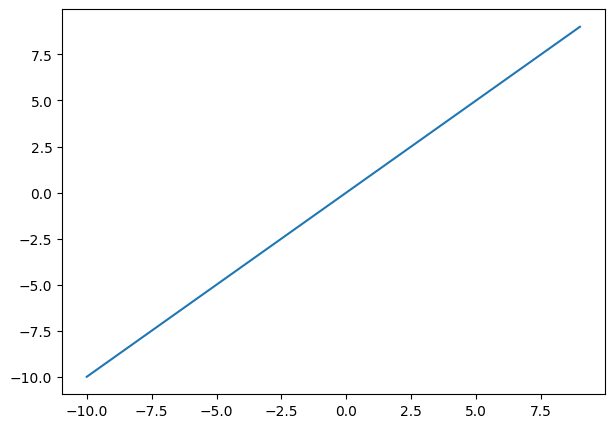

In [44]:
sample_x = torch.arange(-10, 10, 1, dtype=torch.float32) # array of range
sample_y = torch.arange(-10, 10, 1, dtype=torch.float32)

plt.figure(figsize=(7, 5), dpi=100)
plt.plot(sample_x, sample_y)
plt.show()

<br>

### 1) ReLU

In [58]:
def relu(x):
    
    return torch.relu(torch.max(torch.tensor(0), x)) # ReLU == MAX(0, X)

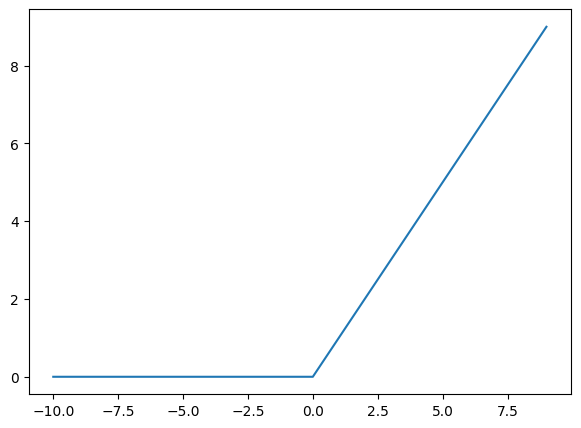

In [59]:
relu_output = relu(sample_x)

plt.figure(figsize=(7, 5), dpi=100)
plt.plot(sample_x, relu_output)
plt.show()

<br>

### 2) Sigmoid

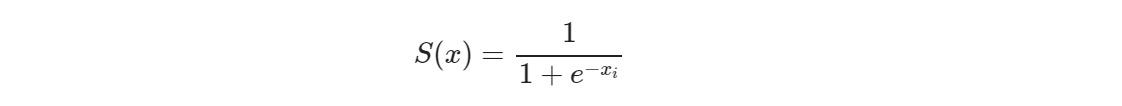

In [60]:
def sigmoid(x):
    
    return 1 / (1 + torch.exp(-x)) # e^(-x) == exponential "-x"

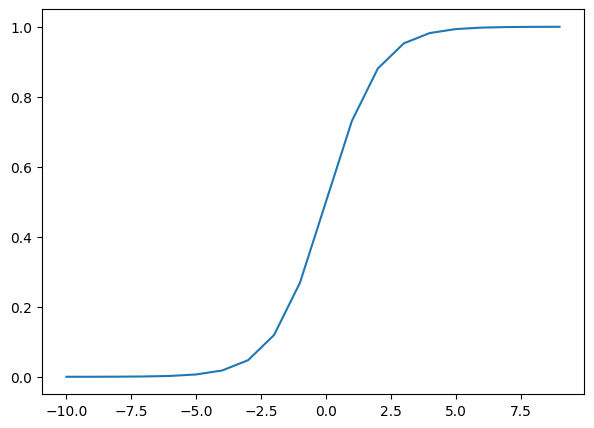

In [61]:
sigmoid_output = sigmoid(sample_x)

plt.figure(figsize=(7, 5), dpi=100)
plt.plot(sample_x, sigmoid_output)
plt.show()